In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial
import dask

from scipy import ndimage

In [2]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [3]:
#%automagic

In [4]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()

plt.rc('text', usetex=False)


In [5]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds


In [6]:
def calc_disp_flux(ds):

    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    w_disp = ds['w'] - ds['w'].mean('x').mean('y')

    theta_disp = ds['theta_interpolated'] - ds['theta_interpolated'].mean('x').mean('y')
    q_disp = ds['q_interpolated'] - ds['q_interpolated'].mean('x').mean('y')

    wtheta_disp = (w_disp * theta_disp).mean('x').mean('y').compute()*(1.17*1005)
    wq_disp = (w_disp * q_disp).mean('x').mean('y').compute()*(1.17*1000*2501)
    
    return wtheta_disp, wq_disp


In [7]:
def calc_hzntl_disp_flux(ds,var):

    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    if var == 'u': var_disp = (ds['u'] - ds['u'].mean('xu').mean('y')).rename({'xu': 'x','zu_3d': 'zw_3d'}).interp_like(ds.w)
    if var == 'v': var_disp = (ds['v'] - ds['v'].mean('x').mean('yv')).rename({'yv': 'y','zu_3d': 'zw_3d'}).interp_like(ds.w)

    theta_disp = ds['theta_interpolated'] - ds['theta_interpolated'].mean('x').mean('y')
    q_disp = ds['q_interpolated'] - ds['q_interpolated'].mean('x').mean('y')

    vartheta_disp = (var_disp * theta_disp).mean('x').mean('y').compute()*(1.17*1005)
    varq_disp = (var_disp * q_disp).mean('x').mean('y').compute()*(1.17*1000*2501)
    
    return vartheta_disp, varq_disp


In [8]:
def _subset_process_time_hom(ds,var,iop):    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time_hom(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]':
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
        
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)


In [9]:
#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files_hom(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time_hom, var=var,iop=iop)
            # open_mfdataset() called without chunks argument will return dask arrays with chunk sizes 
            # equal to the individual files. Re-chunking the dataset after creation with ds.chunk() will 
            # lead to an ineffective use of memory and is not recommended
            ds = xr.open_mfdataset(file_list,preprocess=partial_func,chunks={'time': 8}) 
            ds.close()
            #check if the time index has only unique values 
            u, c = np.unique(ds.time.values, return_counts=True)
            #if not, keep the second, latest value for the ds
            if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')

            print('Member',str(member_num),'finished collecting data')
            
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time_hom,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        #check if the time index has only unique values 
        u, c = np.unique(ds.time.values, return_counts=True)
        #if not, keep the second, latest value for the ds
        if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')
        
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

Data prep:

Read in the domain averaged profile data from N03, to have a look at values

In [10]:
profile_P_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
profile_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.0017750971019268 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.9220773093402386 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.7725205235183239 seconds


In [11]:
# profile_P_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds_hom = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
# profile_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')

['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.20703449100255966 seconds


In [12]:
profile_P_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop03')
profile_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03')
profile_N03_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.8978442959487438 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.8400198668241501 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.7526771202683449 seconds


In [13]:
profile_N02_member_2_ds_iop03_hom = open_concat_member_files_hom(2,'DATA_1D_PR_NETCDF_N02slice','iop03')


['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.23624222353100777 seconds


In [14]:
ensemble_member_ds_2_P = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
ensemble_member_ds_2_N02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
#ensemble_member_ds_2_N03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  2.9191730841994286 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3247670792043209 seconds


In [15]:
ensemble_member_ds_2_P_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop03')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
#ensemble_member_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  2.3296772204339504 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3255128972232342 seconds


In [16]:
# ensemble_member_ds_2_P_surf = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop02')
# ensemble_member_ds_2_N02_surf = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')


Read in all ensembles into one ds, for a subset of variables (edit the function description above to edit the variables intaken)

In [17]:
member_list = np.arange(1,9)

# ensemble_ds_iop02_P_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDFslice','iop02')
# ensemble_ds_iop02_P = xr.concat(ensemble_ds_iop02_P_list,dim='ensemble')

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  2.8629390336573124 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.27270208671689034 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  2.3856738284230232 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  2.244

In [18]:
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list_hom = open_concat_member_files_hom(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02_hom = xr.concat(ensemble_ds_iop02_N02_list_hom,dim='ensemble')


['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  1.1109792068600655 seconds
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.06674226745963097 seconds
['00.ches_IOP2_parent_child1_hom3.8694', '01.ches_IOP2_parent_child1_hom3.9492', '02.ches_IOP2_parent_child1_hom3.14926', '03.ches_IOP2_parent_child1_hom3.22232']
Member 3 finished collecting data
Done with member 3  Time elapsed  1.0844150073826313 seconds
['00.ches_IOP2_parent_child1_hom4.31521', '01.ches_IOP2_parent_child1_hom4.20276', '02.ches_IOP2_parent_child1_hom4.808', '03.ches_IOP2_parent_child1_hom4.13218']
Member 4 finished collecting data
Done with member 4  Time elapsed  1.1845030561089516 seconds
['0.ches_IOP2_parent_child1_hom5.19920', '01.ches_

In [19]:
#ensemble_ds_iop02_N02

In [20]:
member_list = np.arange(0,8)

# ensemble_ds_iop02_P_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDFslice','iop02')
# ensemble_ds_iop02_P = xr.concat(ensemble_ds_iop02_P_list,dim='ensemble')

ensemble_ds_iop03_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02 = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.8070831522345543 seconds
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.3456118628382683 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.270687

In [21]:
member_list = np.arange(1,9)

ensemble_ds_iop03_N02_list = open_concat_member_files_hom(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02_hom = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['0.ches_IOP3_parent_child1_hom1.12767', '1.ches_IOP3_parent_child1_hom1.14954']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.06951969116926193 seconds
['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.06734337285161018 seconds
['0.ches_IOP3_parent_child1_hom3.21914', '1.ches_IOP3_parent_child1_hom3.9923']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.06625396758317947 seconds
['0.ches_IOP3_parent_child1_hom4.7100', '1.ches_IOP3_parent_child1_hom4.11437']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.06680715829133987 seconds
['0.ches_IOP3_parent_child1_hom5.14681', '01.ches_IOP3_parent_child1_hom5.10912']
Member 5 finished collecting data
Done with member 5  Time elapsed  0.06580807268619537 seconds
['0.ches_IOP3_parent_child1_hom.14466', '01.ches_IOP3_parent_child1_hom.8882', '02.ches_IOP3_parent_child1_hom.27783'

In [22]:
#ensemble_ds_iop03_N02

Time series:


In [23]:
# #while reading in time-series data don't round up to the nearest minute
# ts_N02_member_2_ds = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop02')
# ts_N03_member_2_ds = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N03slice','iop02')

In [24]:
IOP02_time_array = ['2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000']

#using theta_v from one member
# w_star_list_iop02 = [0.72704178, 0.81614358, 1.12879522, 1.30232736, 1.61917277,
#        1.80759246, 1.77448817, 1.87499538, 2.06314169, 2.0434414 ,
#        1.98565608, 1.88895816, 1.92537669, 1.90143498, 1.80497102] #0900 to 1600

# w_star_list_iop02_hom = [1.49230529, 2.01246296, 2.00524245, 2.13827292, 2.24205   ,
#        2.16141471, 2.09036846, 2.07836994, 2.04643539, 1.94841107,
#        1.81037627] #1100 to 1600

# zi_iop02 = [ 128.4789129 ,  186.29704611,  402.40461573,  485.38067276,
#         906.50266875, 1256.90609044, 1255.68711072, 1428.77175317,
#        1573.09371352, 1556.12316329, 1609.16728002, 1625.39083092,
#        1628.12380486, 1633.47266652, 1634.52013366] 

# zi_iop02_hom = [ 134.78798842,  170.09851637,  250.96092671,  421.89342838,
#         516.82318556, 1263.28327913, 1238.05916685, 1417.9678503 ,
#        1570.46841613, 1542.68049009, 1562.49650256, 1588.34261528,
#        1577.34207173, 1614.45957674, 1632.99747828]

# u_star_array_iop02 = [0.23746523, 0.26933923, 0.34820446, 0.3888348 , 0.41974205,
#        0.4338308 , 0.42021513, 0.41170758, 0.427308  , 0.4327292 ,
#        0.41003117, 0.37822667, 0.37520644, 0.37473503, 0.35841644]

#using theta, ensemble mean
zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 
zi_iop02_hom = [ 524.81832925, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773]

#zi_iop02_hom = 

In [27]:
IOP03_time_array = ['2019-09-24T09:00:00.000000000', '2019-09-24T09:30:00.000000000',
       '2019-09-24T10:00:00.000000000', '2019-09-24T10:30:00.000000000',
       '2019-09-24T11:00:00.000000000', '2019-09-24T11:30:00.000000000',
       '2019-09-24T12:00:00.000000000', '2019-09-24T12:30:00.000000000',
       '2019-09-24T13:00:00.000000000', '2019-09-24T13:30:00.000000000',
       '2019-09-24T14:00:00.000000000', '2019-09-24T14:30:00.000000000']

zi_iop03 = [  88.62130987,  141.84283359,  225.54037425,  322.57451548,
        396.33941635,  475.2585832 ,  592.48186233,  679.5148229 ,
        758.12848296,  849.92848296,  958.90627311, 1030.6234217 ]
zi_iop03_hom = [ 80.69513477, 126.33890844, 184.98307418, 279.36109601,
       363.49589218, 491.99541546, 652.15589218, 750.80264201,
       826.63606594, 885.59620405, 933.9983738 , 977.12602361]


In [26]:
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168


Calculate the horizontal spatial variance profiles for 23 Aug and 24 Sep.

In [35]:
def spatial_variance(ds,member_list,time_step,zi,var='w'):

    variance_profile_list = []
    for member_num in member_list:
        #calculate variance

        #subset for the variable, var and time
        var_ds = ds[var].sel(time=time_step,zw_3d=slice(0,zi+200))

        #select the required number of ensembles
        var_hi = var_ds.sel(ensemble=slice(0,member_num)).mean('ensemble')
        #calculate spatial mean
        spatial_mean  = var_hi.mean('x').mean('y').compute()
        #calculate deviation from spatial mean and variance
        spatial_variance = (((var_hi - spatial_mean)**2).mean('x').mean('y').compute())
        #subset for ABL height, calculate mean
        #variance_abl_mean = spatial_variance.sel(zw_3d=slice(0,zi)).mean()
        #add value to the variance list
        variance_profile_list.append(spatial_variance)
        print('Member ' + str(member_num) + ' done!')
    return variance_profile_list


In [28]:
ds_het = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))


In [31]:
IOP02_time_array[6]

'2019-08-23T12:00:00.000000000'

In [50]:
#12
time_step = IOP02_time_array[6]
zi = zi_iop02[6]
#variance_list_12 = spatial_variance(ds_het,np.arange(1,8),time_step,zi)
variance_list_12_member8 = spatial_variance(ds_het,np.arange(8,9),time_step,zi)


[########################################] | 100% Completed | 112.47 s
[########################################] | 100% Completed | 146.59 s
Member 8 done!


In [44]:
variance_list_12_ds = xr.concat(variance_list_12, 'member')
variance_list_12_ds

<xarray.DataArray 'w' (member: 7, zw_3d: 121)>
array([[       nan, 0.00184597, 0.00658128, 0.01322313, 0.02105733,
        0.02950818, 0.03824247, 0.04724181, 0.05648655, 0.06601547,
        0.07585551, 0.08600313, 0.09641983, 0.10706081, 0.11787696,
        0.12882887, 0.1398744 , 0.15096845, 0.16204813, 0.17302881,
        0.18383393, 0.19439822, 0.20466664, 0.21459259, 0.22414027,
        0.23328038, 0.24198495, 0.25022697, 0.25796536, 0.2651532 ,
        0.27175272, 0.27773783, 0.28308854, 0.2877994 , 0.2918807 ,
        0.29534328, 0.2982031 , 0.30047253, 0.30215642, 0.3032574 ,
        0.30377734, 0.30370924, 0.30304843, 0.3017999 , 0.2999834 ,
        0.29762533, 0.29476133, 0.29142454, 0.28763774, 0.28342542,
        0.27881142, 0.27381834, 0.2684696 , 0.26279065, 0.25680667,
        0.25054318, 0.24402997, 0.23729865, 0.23037659, 0.22328956,
        0.21605694, 0.20869382, 0.20120545, 0.19360115, 0.18590721,
        0.17816   , 0.17039844, 0.1626568 , 0.15495771, 0.14731716,
        0.1397616 , 0.13232413, 0.12503442, 0.11791594, 0.11099058,
        0.10428154, 0.09780744, 0.09157347, 0.08558192, 0.07983428,
        0.07432873, 0.06906705, 0.06405916, 0.05931554, 0.05485055,
        0.05068395, 0.04683434, 0.04330842, 0.04010268, 0.03720992,
        0.03462043, 0.03232188, 0.03029747, 0.02852502, 0.0269823 ,
        0.02564449, 0.02449283, 0.02352468, 0.02273916, 0.02212204,
...
        0.05451568, 0.05713923, 0.05969501, 0.0621759 , 0.06457395,
        0.06688145, 0.06909098, 0.07119482, 0.07318543, 0.07505403,
        0.07679199, 0.07839339, 0.0798538 , 0.08116847, 0.0823327 ,
        0.08334182, 0.08419024, 0.08487286, 0.08538711, 0.08573335,
        0.08591368, 0.08593196, 0.08579113, 0.08549127, 0.08503361,
        0.0844216 , 0.08365938, 0.08274963, 0.08169413, 0.08049568,
        0.07915771, 0.07768412, 0.07607966, 0.07435144, 0.0725097 ,
        0.07056676, 0.06853431, 0.06642304, 0.0642433 , 0.06200527,
        0.05971983, 0.05739737, 0.05504448, 0.05266569, 0.05026483,
        0.04784786, 0.04542388, 0.04300343, 0.0405976 , 0.03821671,
        0.03587058, 0.0335682 , 0.03131875, 0.0291318 , 0.02701657,
        0.02498137, 0.02303487, 0.02118595, 0.01944116, 0.01780515,
        0.01628214, 0.01487578, 0.01358698, 0.01241409, 0.01135399,
        0.01040337, 0.00955846, 0.00881472, 0.00816651, 0.00760625,
        0.00712492, 0.00671405, 0.00636575, 0.00607136, 0.00582222,
        0.00561099, 0.00543117, 0.00527576, 0.00513929, 0.00501741,
        0.00490728, 0.00480698, 0.00471351, 0.00462489, 0.00454059,
        0.00445921, 0.00437998, 0.00430348, 0.00423143, 0.00416628,
        0.00411002, 0.00406366, 0.00402799, 0.00400287, 0.00398587,
        0.00397264]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-08-23T12:00:00
  * zw_3d    (zw_3d) float64 0.0 12.0 24.0 36.0 ... 1.416e+03 1.428e+03 1.44e+03
Dimensions without coordinates: member

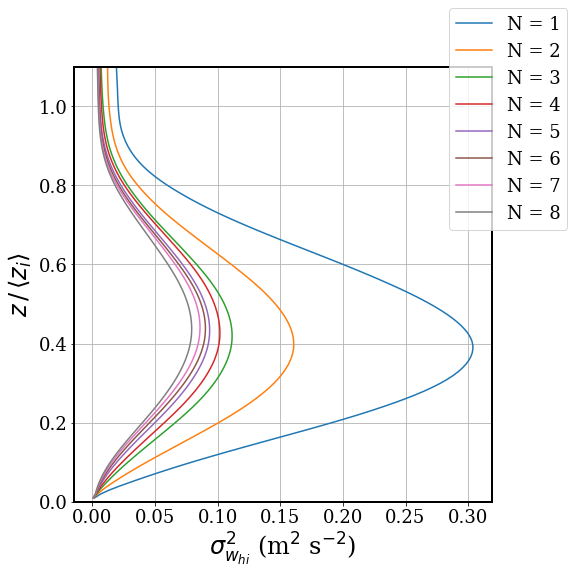

In [58]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

for member_num in np.arange(0,7):
    y_axis = variance_list_12_ds.zw_3d/zi
    ax.plot(np.asarray(variance_list_12_ds.sel(member=member_num)),y_axis,'-',label= 'N = ' + str(member_num+1))

ax.plot(variance_list_12_member8[0].values,y_axis,'-',label= 'N = 8')


ax.set_ylim([0,1.1])
fig.legend()
fig.subplots_adjust(right=0.85)
ax.set_xlabel(r'$\sigma^{2}_{w_{hi}}}$ (m$^{2}$ s$^{-2}$)',fontsize=24)# w wind
ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.grid(True)
output_fname = 'plots/ensemble_w_hi_var_iop02_1200.png'
plt.savefig(output_fname,dpi=300)

repeat the same for iop03

In [60]:
ds_het_iop03 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))


In [61]:
IOP03_time_array[6]

'2019-09-24T12:00:00.000000000'

In [64]:
#12
time_step = IOP03_time_array[6]
zi = zi_iop03[6]
variance_list_12_iop03 = spatial_variance(ds_het_iop03,np.arange(1,9),time_step,zi)


[########################################] | 100% Completed | 2.85 ss
[########################################] | 100% Completed | 2.12 ss
Member 1 done!
[########################################] | 100% Completed | 5.55 sms
[########################################] | 100% Completed | 4.23 sms
Member 2 done!
[########################################] | 100% Completed | 8.66 sms
[########################################] | 100% Completed | 6.04 sms
Member 3 done!
[########################################] | 100% Completed | 11.26 ss
[########################################] | 100% Completed | 9.47 sms
Member 4 done!
[########################################] | 100% Completed | 15.16 ss
[########################################] | 100% Completed | 13.61 ss
Member 5 done!
[########################################] | 100% Completed | 18.82 ss
[########################################] | 100% Completed | 16.53 ss
Member 6 done!
[########################################] | 100% Completed 

In [65]:
variance_list_12_ds_iop03 = xr.concat(variance_list_12_iop03, 'member')
variance_list_12_ds_iop03

<xarray.DataArray 'w' (member: 8, zw_3d: 67)>
array([[       nan, 0.00168149, 0.00579992, 0.01047279, 0.01591028,
        0.02188979, 0.02795639, 0.03387952, 0.0394947 , 0.04472294,
        0.04952101, 0.05385554, 0.05768722, 0.06099429, 0.06375843,
        0.06596665, 0.06762449, 0.06873813, 0.06931785, 0.06937773,
        0.06893671, 0.06802935, 0.06670361, 0.06501018, 0.06299712,
        0.06070983, 0.05819578, 0.05550301, 0.05267035, 0.04973377,
        0.046728  , 0.04368935, 0.04065948, 0.03767791, 0.03478162,
        0.03199913, 0.02935603, 0.02688529, 0.02460486, 0.02252568,
        0.02066322, 0.0190356 , 0.01767573, 0.01662033, 0.01589424,
        0.0155056 , 0.01544638, 0.01570871, 0.01630607, 0.01725186,
        0.01855027, 0.02018013, 0.02207569, 0.02413699, 0.0262592 ,
        0.02833972, 0.03026268, 0.03191179, 0.03318957, 0.03403242,
        0.03440844, 0.03432443, 0.03382329, 0.03298099, 0.03189094,
        0.03063982, 0.02929727],
       [       nan, 0.00131801, 0.00446446, 0.00699785, 0.00952634,
        0.01225183, 0.01505134, 0.01780957, 0.02041238, 0.02280033,
        0.0249436 , 0.02682439, 0.02842234, 0.02972351, 0.03072041,
        0.03141297, 0.03181497, 0.03194575, 0.03182882, 0.03148775,
        0.03094245, 0.03021473, 0.02932288, 0.02828361, 0.02711485,
        0.02583799, 0.024476  , 0.02305115, 0.02158546, 0.0200972 ,
...
        0.0068947 , 0.00736817, 0.00800293, 0.00878042, 0.00967271,
        0.01064536, 0.01165892, 0.01267131, 0.01364361, 0.01454367,
        0.01534726, 0.01604018, 0.01661553, 0.01707253, 0.01741637,
        0.01765618, 0.01780485, 0.01787599, 0.01788054, 0.01782704,
        0.01772247, 0.0175722 , 0.01737993, 0.01714946, 0.01688609,
        0.016596  , 0.01628612],
       [       nan, 0.00103495, 0.00340921, 0.00442523, 0.00518225,
        0.00618411, 0.00742397, 0.00880724, 0.01023393, 0.0116375 ,
        0.01296947, 0.01419577, 0.01529026, 0.01623191, 0.01700762,
        0.01761224, 0.01804599, 0.01831213, 0.01841572, 0.01836207,
        0.0181565 , 0.01780668, 0.01732304, 0.01671848, 0.01600925,
        0.0152145 , 0.01435363, 0.01344643, 0.01251263, 0.01157315,
        0.01064993, 0.00976418, 0.00893665, 0.00818899, 0.0075436 ,
        0.00702207, 0.00664322, 0.00642034, 0.00636214, 0.00647473,
        0.00676202, 0.0072227 , 0.00784602, 0.00861349, 0.00949809,
        0.01046683, 0.01148126, 0.01249965, 0.01348271, 0.01439784,
        0.01522063, 0.0159358 , 0.01653442, 0.0170134 , 0.01737539,
        0.01762811, 0.01778466, 0.01785991, 0.01786638, 0.01781391,
        0.0177101 , 0.01756083, 0.01737039, 0.0171428 , 0.01688309,
        0.01659721, 0.01629203]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-09-24T12:00:00
  * zw_3d    (zw_3d) float64 0.0 12.0 24.0 36.0 48.0 ... 756.0 768.0 780.0 792.0
Dimensions without coordinates: member

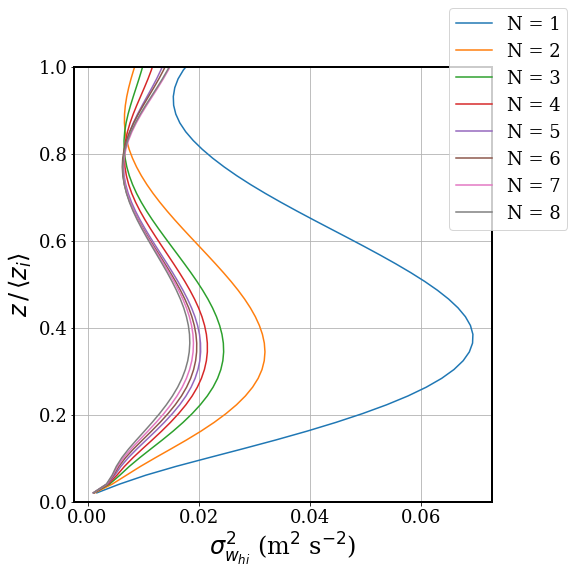

In [67]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

for member_num in np.arange(0,8):
    y_axis = variance_list_12_ds_iop03.zw_3d/zi
    ax.plot(np.asarray(variance_list_12_ds_iop03.sel(member=member_num)),y_axis,'-',label= 'N = ' + str(member_num+1))

ax.set_ylim([0,1.0])
fig.legend()
fig.subplots_adjust(right=0.85)
ax.set_xlabel(r'$\sigma^{2}_{w_{hi}}}$ (m$^{2}$ s$^{-2}$)',fontsize=24)# w wind
ax.set_ylabel(r'$z\, /\, \langle z_{i} \rangle $',fontsize=24)
ax.grid(True)
# output_fname = 'plots/ensemble_w_hi_var_iop03_1200.png'
# plt.savefig(output_fname,dpi=300)